### Agent Function Call with Qwen3-VL

This notebook demonstrates how to use Qwen3-VL's agent function call capabilities to interact with a mobile device. It showcases the model's ability to generate and execute actions based on user queries and visual context.

#### \[Setup\] 

Load visualization utils.

In [ ]:
!pip install git+https://github.com/huggingface/transformers
!pip install qwen-vl-utils
!pip install qwen_agent
!pip install openai
!pip install icecream

In [2]:
## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
import os
os.environ['DASHSCOPE_API_KEY'] = "your api key"

In [10]:
import os.path as osp
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from icecream import ic
import math
from PIL import Image, ImageDraw, ImageFont, ImageColor

def draw_point(image: Image.Image, point: list, color=None):
    from copy import deepcopy
    if isinstance(color, str):
        try:
            color = ImageColor.getrgb(color)
            color = color + (128,)  
        except ValueError:
            color = (255, 0, 0, 128)  
    else:
        color = (255, 0, 0, 128)  
 
    overlay = Image.new('RGBA', image.size, (255, 255, 255, 0))
    overlay_draw = ImageDraw.Draw(overlay)
    radius = min(image.size) * 0.05
    x, y = point

    overlay_draw.ellipse(
        [(x - radius, y - radius), (x + radius, y + radius)],
        fill=color  # Red with 50% opacity
    )

    image = image.convert('RGBA')
    combined = Image.alpha_composite(image, overlay)

    return combined.convert('RGB')

def rescale_coordinates(point, width, height):
    point = [round(point[0]/999*width), round(point[1]/999*height)]
    return point

#### 1. Mobile Use

##### [Example] English App & Query with API

Thought: To search for Musk in X, I need to click on the search bar at the top of the screen. This will allow me to type in the search query.
Action: "I tapped on the search bar to begin searching for Musk."
<tool_call>
{"name": "mobile_use", "arguments": {"action": "click", "coordinate": [447, 81]}}
</tool_call>


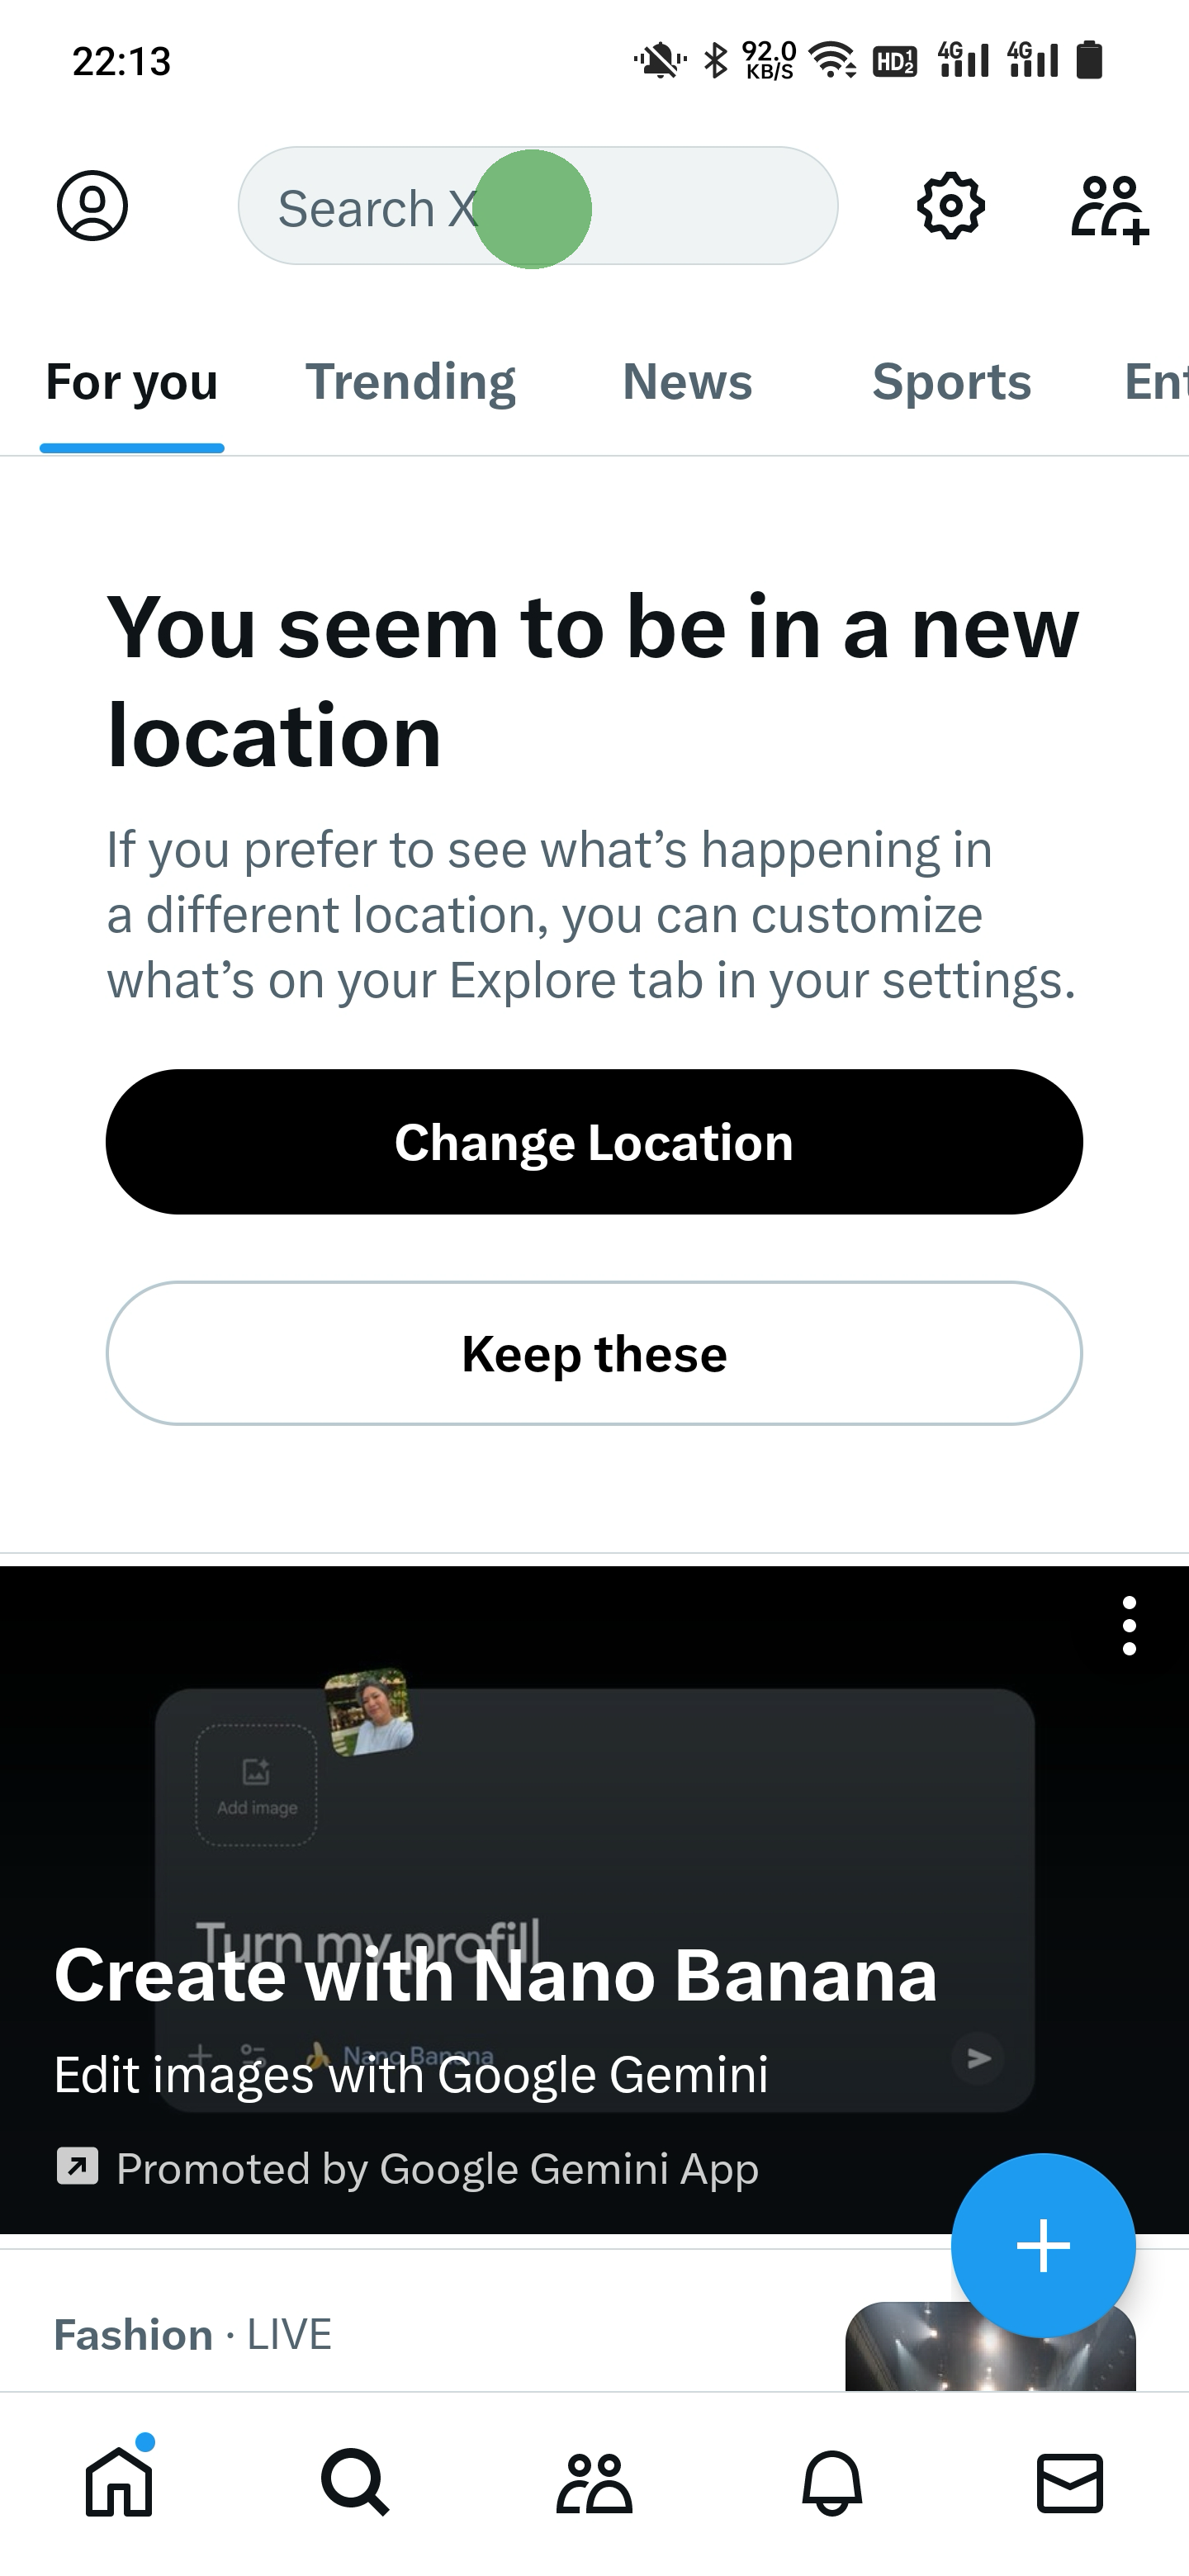

In [ ]:
from qwen_agent.llm.fncall_prompts.nous_fncall_prompt import (
    NousFnCallPrompt,
    Message,
    ContentItem,
)
from qwen_vl_utils import smart_resize
import json
from PIL import Image
from utils.agent_function_call import MobileUse

from IPython.display import display
import base64
#  base 64 编码格式
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")
from openai import OpenAI

# Prapare your screenshot file and global query

model_id="qwen3vl-235A22-instruct"

screenshot = "./assets/agent_function_call/mobile_en_example.png"


system_prompt = "\n\n# Tools\n\nYou may call one or more functions to assist with the user query.\n\nYou are provided with function signatures within <tools></tools> XML tags:\n<tools>\n{\"type\": \"function\", \"function\": {\"name\": \"mobile_use\", \"description\": \"Use a touchscreen to interact with a mobile device, and take screenshots.\\n* This is an interface to a mobile device with touchscreen. You can perform actions like clicking, typing, swiping, etc.\\n* Some applications may take time to start or process actions, so you may need to wait and take successive screenshots to see the results of your actions.\\n* The screen's resolution is 999x999.\\n* Make sure to click any buttons, links, icons, etc with the cursor tip in the center of the element. Don't click boxes on their edges unless asked.\", \"parameters\": {\"properties\": {\"action\": {\"description\": \"The action to perform. The available actions are:\\n* `click`: Click the point on the screen with coordinate (x, y).\\n* `long_press`: Press the point on the screen with coordinate (x, y) for specified seconds.\\n* `swipe`: Swipe from the starting point with coordinate (x, y) to the end point with coordinates2 (x2, y2).\\n* `type`: Input the specified text into the activated input box.\\n* `answer`: Output the answer.\\n* `system_button`: Press the system button.\\n* `wait`: Wait specified seconds for the change to happen.\\n* `terminate`: Terminate the current task and report its completion status.\", \"enum\": [\"click\", \"long_press\", \"swipe\", \"type\", \"answer\", \"system_button\", \"wait\", \"terminate\"], \"type\": \"string\"}, \"coordinate\": {\"description\": \"(x, y): The x (pixels from the left edge) and y (pixels from the top edge) coordinates to move the mouse to. Required only by `action=click`, `action=long_press`, and `action=swipe`.\", \"type\": \"array\"}, \"coordinate2\": {\"description\": \"(x, y): The x (pixels from the left edge) and y (pixels from the top edge) coordinates to move the mouse to. Required only by `action=swipe`.\", \"type\": \"array\"}, \"text\": {\"description\": \"Required only by `action=type` and `action=answer`.\", \"type\": \"string\"}, \"time\": {\"description\": \"The seconds to wait. Required only by `action=long_press` and `action=wait`.\", \"type\": \"number\"}, \"button\": {\"description\": \"Back means returning to the previous interface, Home means returning to the desktop, Menu means opening the application background menu, and Enter means pressing the enter. Required only by `action=system_button`\", \"enum\": [\"Back\", \"Home\", \"Menu\", \"Enter\"], \"type\": \"string\"}, \"status\": {\"description\": \"The status of the task. Required only by `action=terminate`.\", \"type\": \"string\", \"enum\": [\"success\", \"failure\"]}}, \"required\": [\"action\"], \"type\": \"object\"}}}\n</tools>\n\nFor each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:\n<tool_call>\n{\"name\": <function-name>, \"arguments\": <args-json-object>}\n</tool_call>\n\n# Response format\n\nResponse format for every step:\n1) Thought: one concise sentence explaining the next move (no multi-step reasoning).\n2) Action: a short imperative describing what to do in the UI.\n3) A single <tool_call>...</tool_call> block containing only the JSON: {\"name\": <function-name>, \"arguments\": <args-json-object>}.\n\nRules:\n- Output exactly in the order: Thought, Action, <tool_call>.\n- Be brief: one sentence for Thought, one for Action.\n- Do not output anything else outside those three parts.\n- If finishing, use action=terminate in the tool call."
# The operation history can be orgnized by Step x: [action]; Step x+1: [action]...
instruction = "Search for Musk in X and go to his homepage to open the first post."

stage2_history = ''
history = [
    "I opened the X app from the home screen.",
]
for idx, his in enumerate(history):
    stage2_history += 'Step ' + str(idx + 1) + ': ' + str(his.replace('\n', '').replace('"', '')) + '; '

user_query = f"The user query: {instruction}.\nTask progress (You have done the following operation on the current device): {stage2_history}.\n"


client = OpenAI(
    #If the environment variable is not configured, please replace the following line with the Dashscope API Key: api_key="sk-xxx".
    # api_key=os.getenv('DASHSCOPE_API_KEY'),

    # base_url="https://dashscope-intl.aliyuncs.com/compatible-mode/v1",
)

# The resolution of the device will be written into the system prompt. 
dummy_image = Image.open(screenshot)

base64_image = encode_image(screenshot)
# Build messages



messages=[
    {
        "role": "system",
        "content": [
            {"type": "text", "text": system_prompt},
        ],
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": user_query},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
            },
            
        ],
    }
]
# print(json.dumps(messages, indent=4))
completion = client.chat.completions.create(
    model = model_id,
    messages = messages,

)

output_text = completion.choices[0].message.content
# Qwen will perform action thought function call
action = json.loads(output_text.split('<tool_call>\n')[1].split('\n</tool_call>')[0])

# As an example, we visualize the "click" action by draw a green circle onto the image.
if action['arguments']['action'] == "click":
    action['arguments']['coordinate'] = rescale_coordinates(action['arguments']['coordinate'], dummy_image.width, dummy_image.height)
    dummy_image = draw_point(dummy_image, action['arguments']['coordinate'], color='green')
    display(dummy_image)
else:
    display(dummy_image)

##### [Example] Chinese App & Query with API

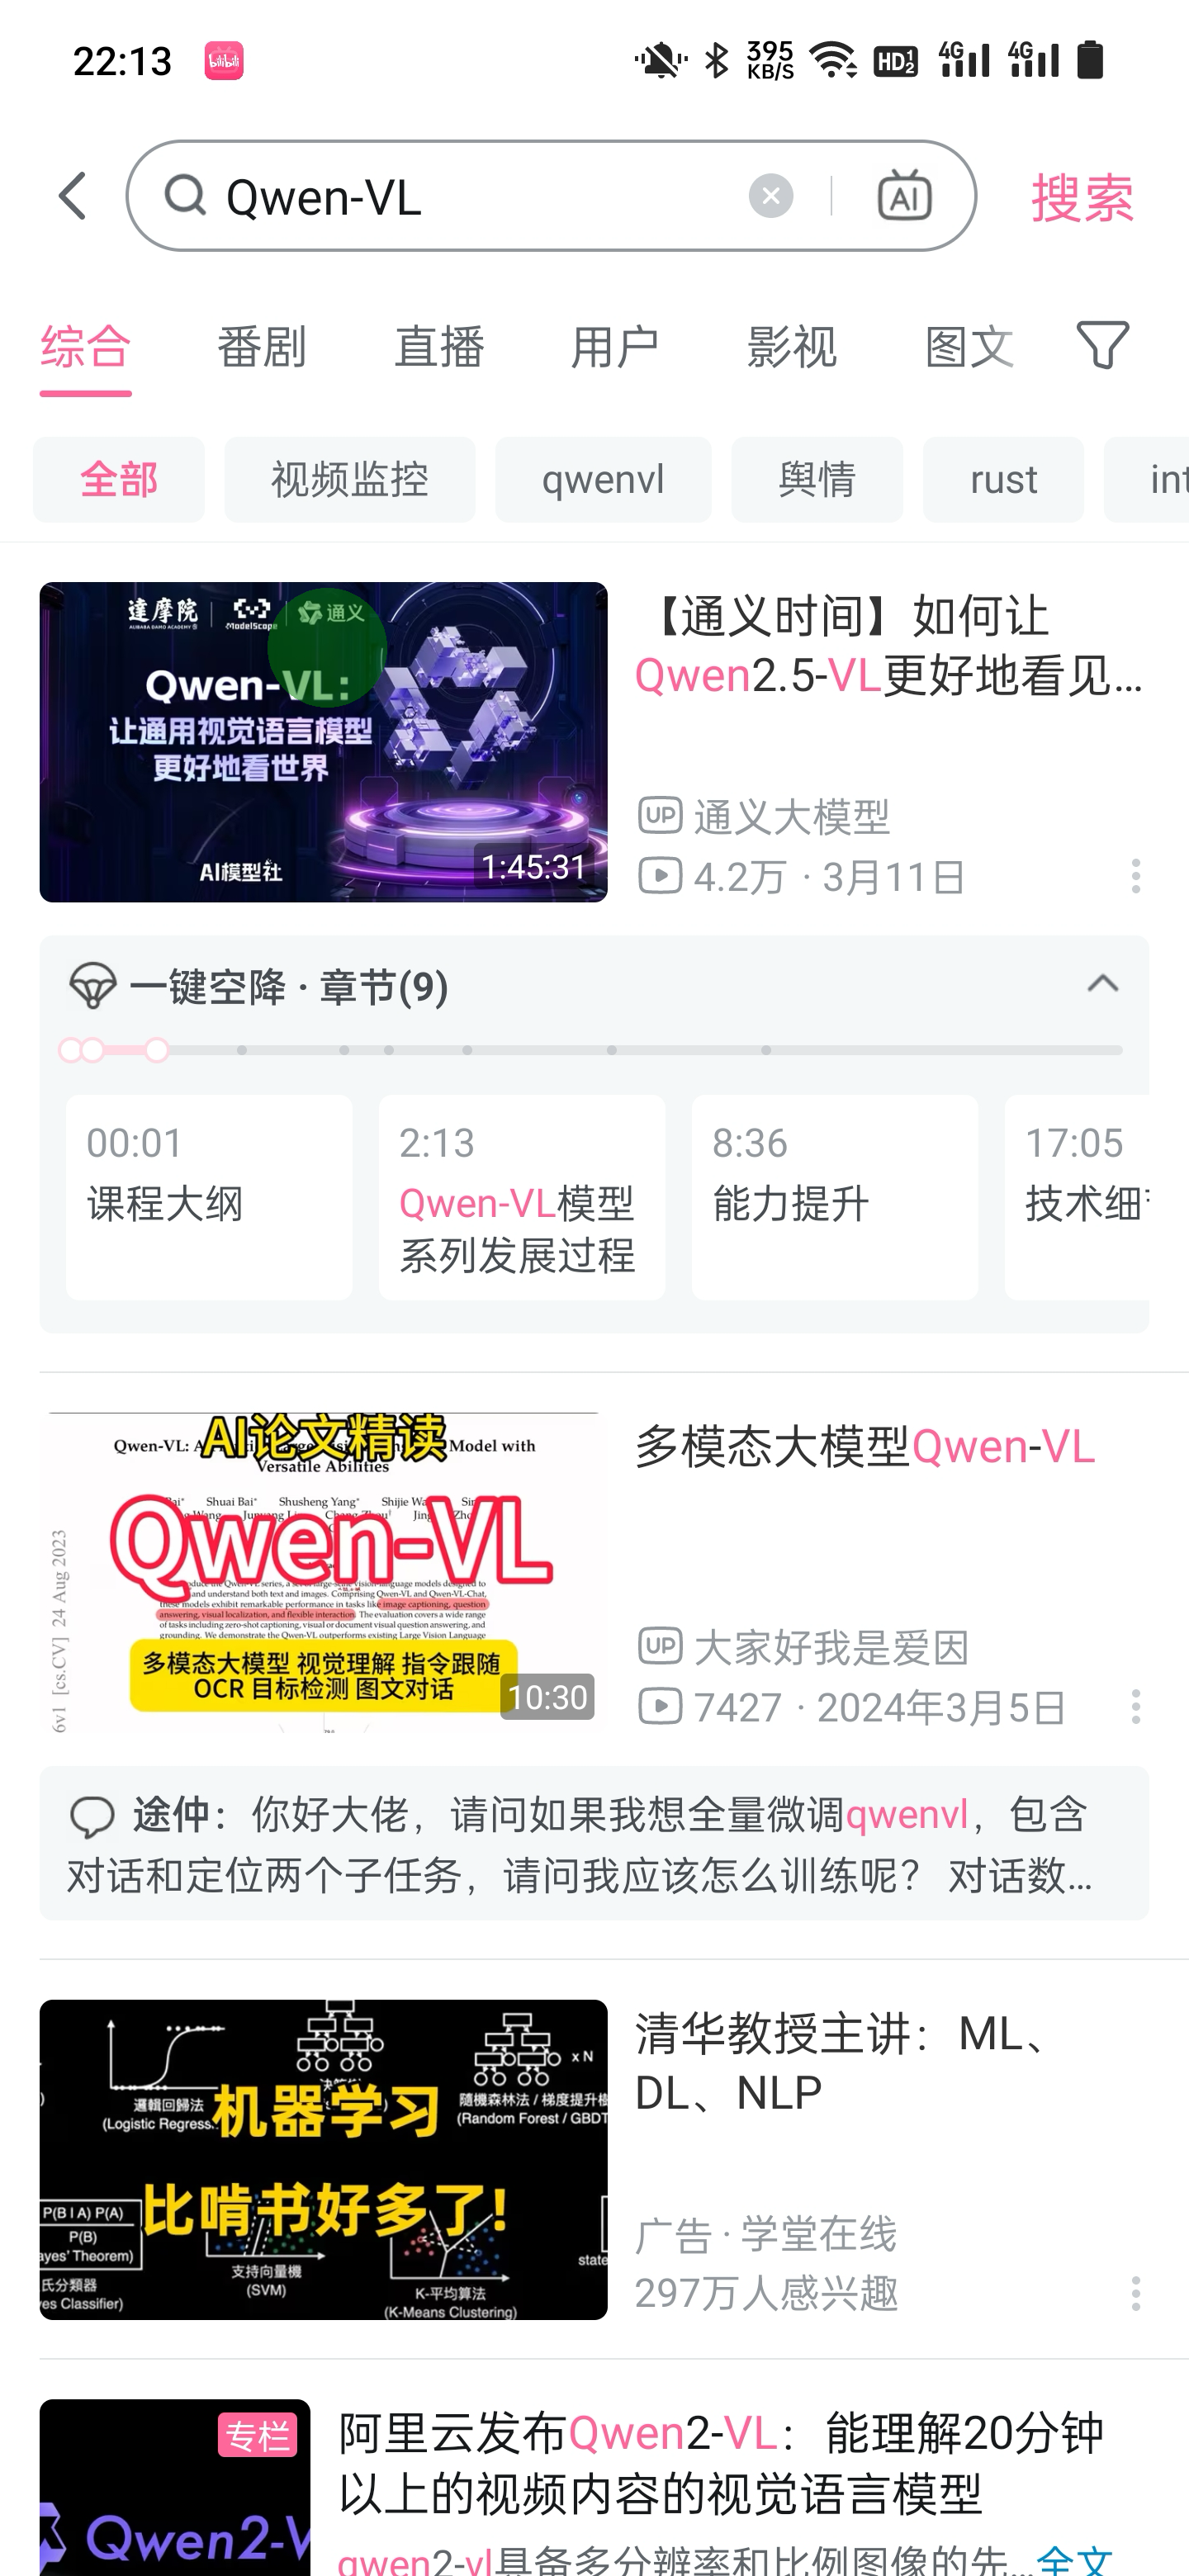

In [ ]:
from qwen_agent.llm.fncall_prompts.nous_fncall_prompt import (
    NousFnCallPrompt,
    Message,
    ContentItem,
)
from qwen_vl_utils import smart_resize
import json
from PIL import Image
from utils.agent_function_call import MobileUse

from IPython.display import display
import base64
#  base 64 编码格式
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")
from openai import OpenAI

# Prapare your screenshot file and global query

model_id="qwen3vl-235A22-instruct"

screenshot = "./assets/agent_function_call/mobile_zh_example.png"





stage2_history = ''
history = [
    "Opening the Bilibili app.",
    "Clicking on the search bar to start searching for Qwen-VL videos.",
    "Type 'Qwen-VL' into the search bar.",
    "Clicking the '搜索' button to initiate the search for Qwen-VL videos.",
]
for idx, his in enumerate(history):
    stage2_history += 'Step ' + str(idx + 1) + ': ' + str(his.replace('\n', '').replace('"', '')) + '; '

user_query = f"The user query: {instruction}.\nTask progress (You have done the following operation on the current device): {stage2_history}.\n"

client = OpenAI(
    #If the environment variable is not configured, please replace the following line with the Dashscope API Key: api_key="sk-xxx".
    # api_key=os.getenv('DASHSCOPE_API_KEY'),
    # base_url="https://dashscope-intl.aliyuncs.com/compatible-mode/v1",
)

# The resolution of the device will be written into the system prompt. 
dummy_image = Image.open(screenshot)

base64_image = encode_image(screenshot)
# Build messages



messages=[
    {
        "role": "system",
        "content": [
            {"type": "text", "text": system_prompt},
        ],
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": user_query},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
            },
            
        ],
    }
]
# print(json.dumps(messages, indent=4))
completion = client.chat.completions.create(
    model = model_id,
    messages = messages,

)

output_text = completion.choices[0].message.content
# Qwen will perform action thought function call
action = json.loads(output_text.split('<tool_call>\n')[1].split('\n</tool_call>')[0])

# As an example, we visualize the "click" action by draw a green circle onto the image.
if action['arguments']['action'] == "click":
    action['arguments']['coordinate'] = rescale_coordinates(action['arguments']['coordinate'], dummy_image.width, dummy_image.height)
    dummy_image = draw_point(dummy_image, action['arguments']['coordinate'], color='green')
    display(dummy_image)
else:
    display(dummy_image)